In [6]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time

In [4]:
## Ben Monsley code =========================================================================

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

def osciHarmSub(gamma, w0, x):
    assert (gamma/2) < w0  # Para o caso subamortecido
    w = np.sqrt(w0**2 - (gamma/2)**2)  # Omega
    phi = np.arctan(-(gamma/2)*w)  # Angulação
    A = 1 / (2 * np.cos(phi))  # Amplitude
    cos = torch.cos(phi + w * x)
    sin = torch.sin(phi + w * x)
    exp = torch.exp(-(gamma/2) * x)
    y = exp * 2 * A * cos
    return y

class RedeConect(nn.Module):
    def __init__(self, N_ENTRADA, N_SAIDA, N_OCULTA, N_CAMADAS):
        super().__init__()
        ativacao = nn.Tanh
        self.entrada = nn.Sequential(*[
                            nn.Linear(N_ENTRADA, N_OCULTA),
                            ativacao()])
        self.ocultas = nn.Sequential(*[
                            nn.Sequential(*[
                                nn.Linear(N_OCULTA, N_OCULTA),
                                ativacao()]) for _ in range(N_CAMADAS-1)])
        self.saida = nn.Linear(N_OCULTA, N_SAIDA)

    def forward(self, x):
        x = self.entrada(x)
        x = self.ocultas(x)
        x = self.saida(x)
        return x
## =========================================================================

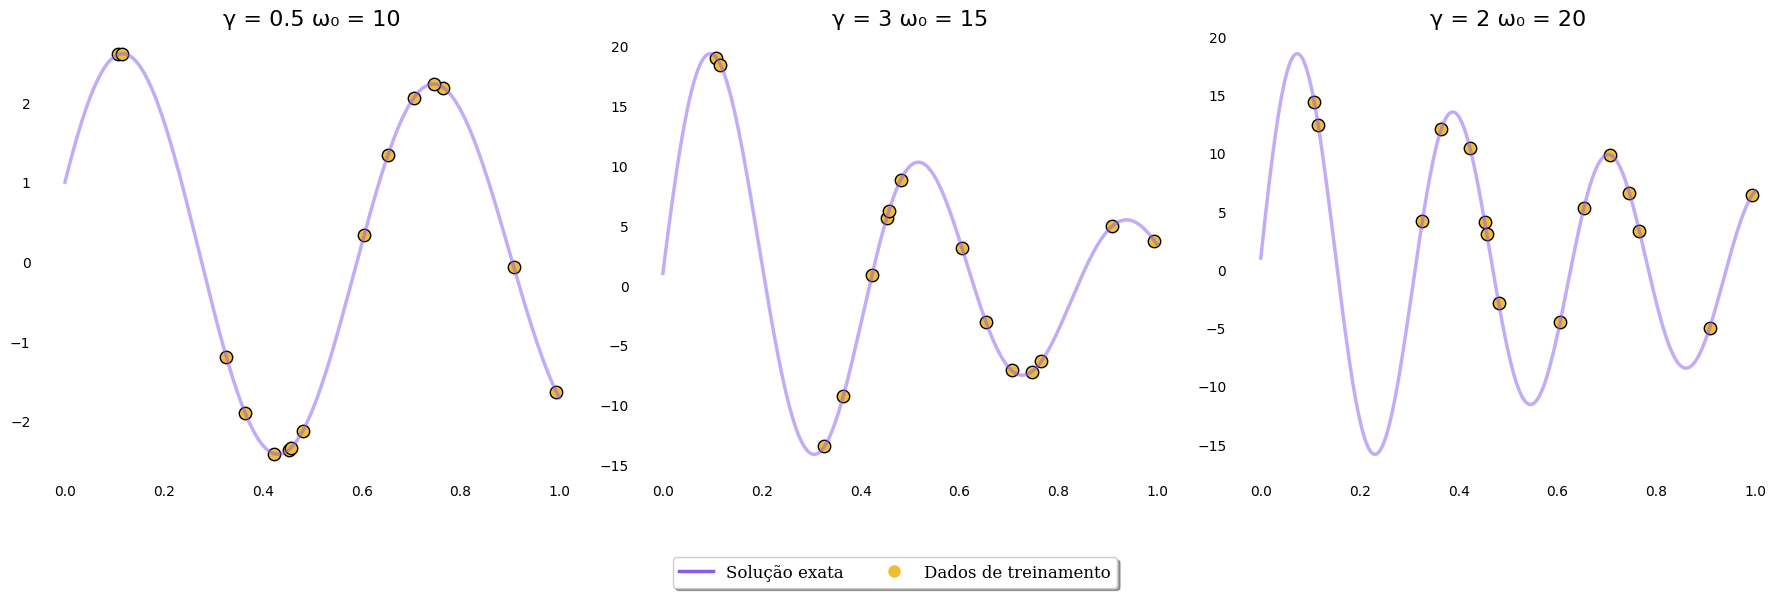

In [5]:
params = [(0.5, 10),(3, 15),(2, 20)]
titles = [f"γ = {gamma} ω₀ = {w0}" for gamma, w0 in params]
num_alea = 15

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = False

for ax, (gamma, w0), title in zip(axs, params, titles):
    x = torch.linspace(0, 1, 500).view(-1, 1)
    y = osciHarmSub(gamma, w0, x).view(-1, 1)

    torch.manual_seed(123)
    indices = torch.randperm(len(x))[:num_alea]
    x_data = x[indices]
    y_data = y[indices]

    ax.plot(x.numpy(), y.numpy(), color="#885BF0", linewidth=2.5, alpha=0.5)
    ax.scatter(x_data.numpy(), y_data.numpy(), color="#EFBD31", edgecolor="black", s=80, marker="o")
    ax.set_title(title, fontsize=16)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)

handles = [
    plt.Line2D([0], [0], color="#885BF0", lw=2.5, label="Solução exata"),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#EFBD31", markersize=10, label='Dados de treinamento')
]
fig.legend(handles=handles, loc="lower center", frameon=True, fancybox=True, shadow=True, fontsize=12, ncol=2)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# REDE INGÊNUA

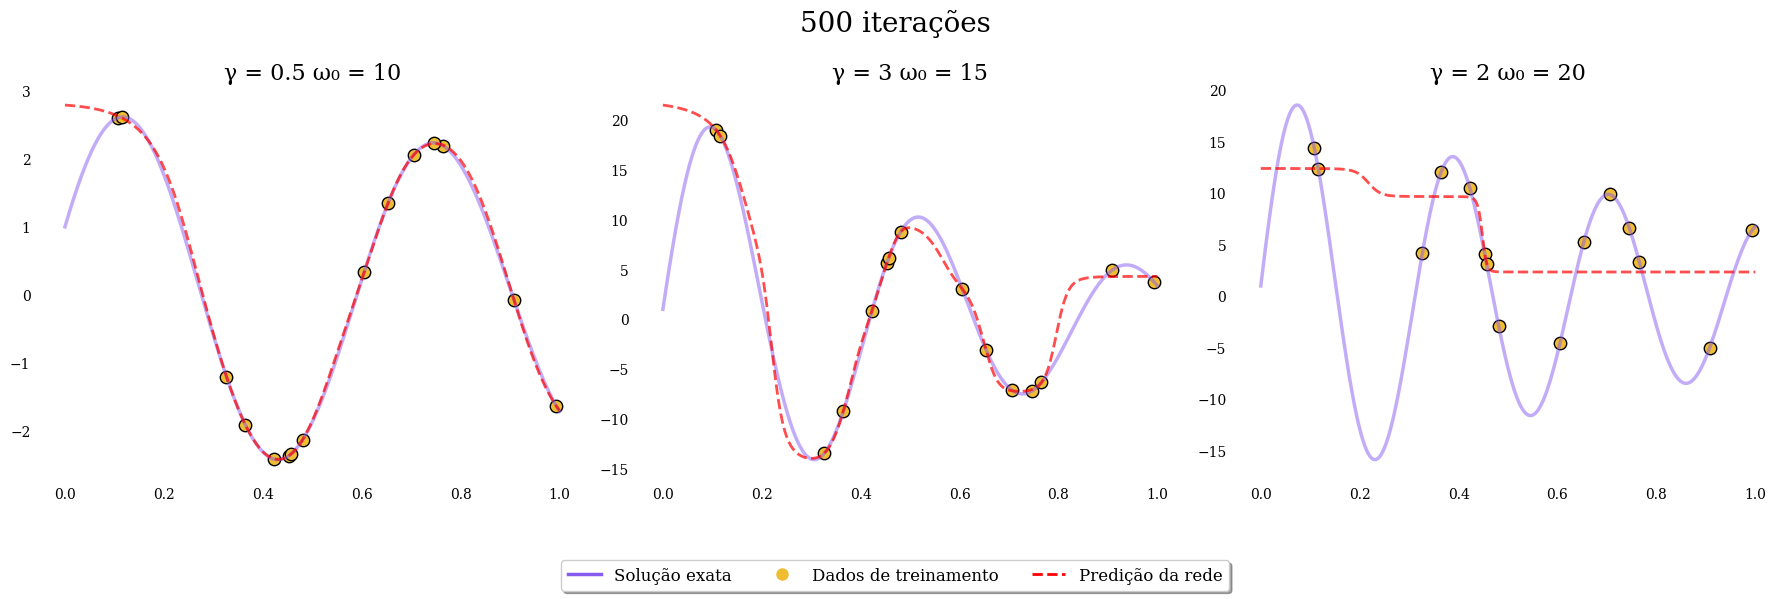

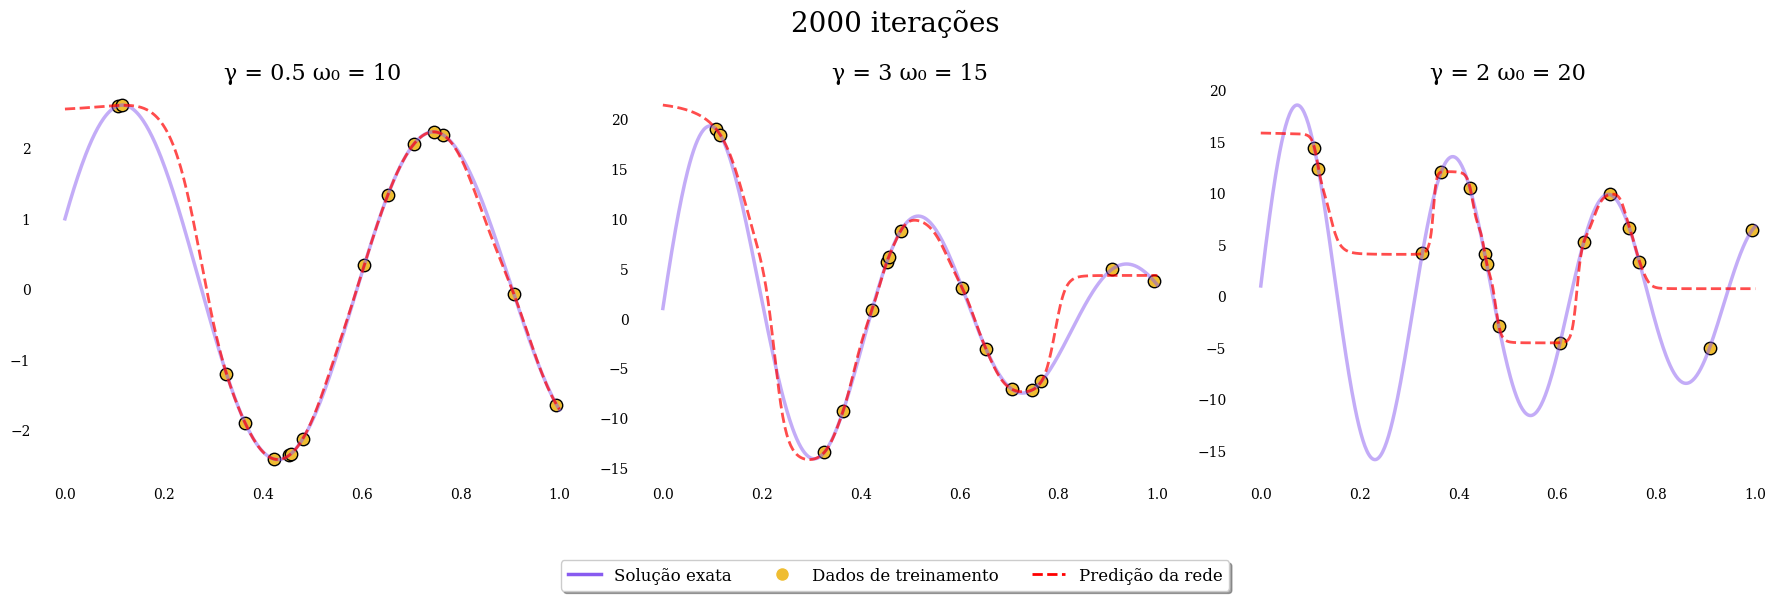

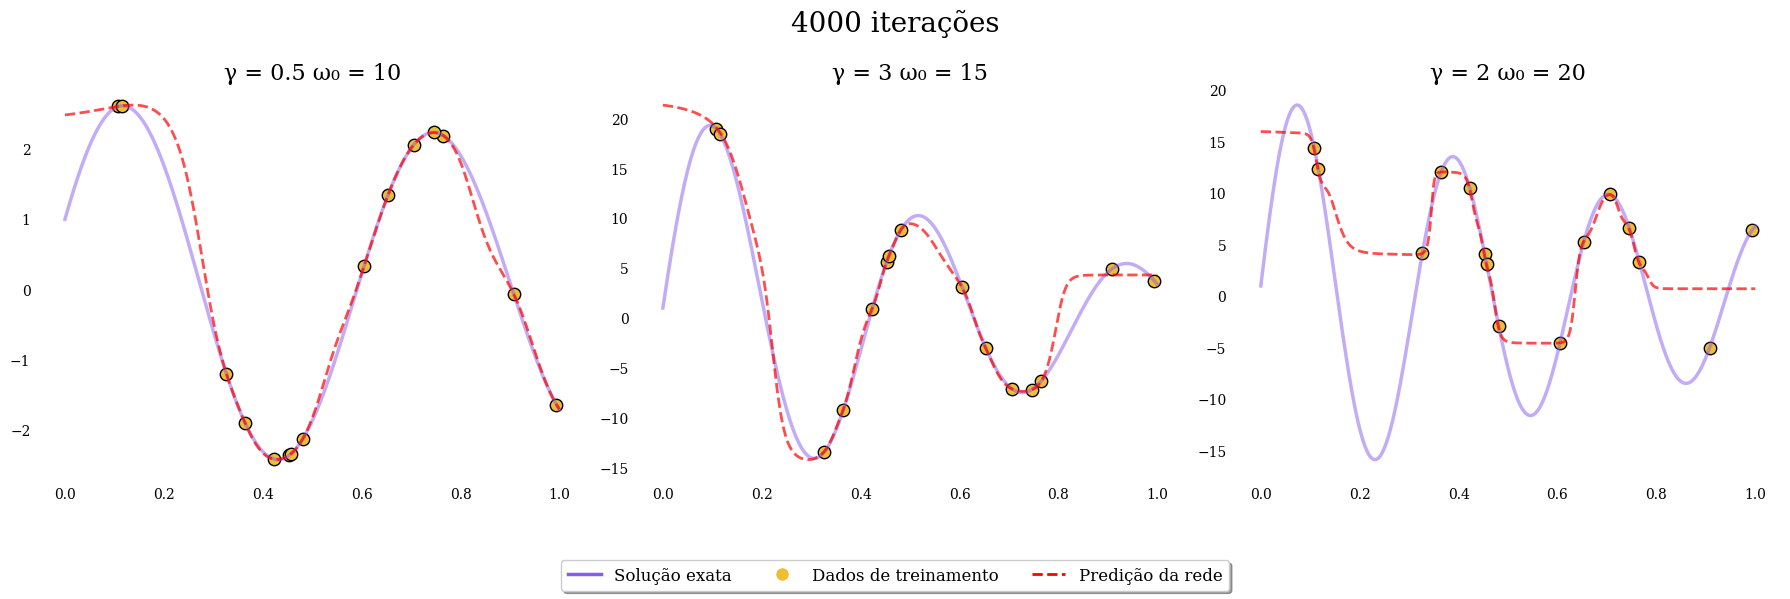

Resultados (Execução em segundos, MAE, MAPE, RMSE, MSE) para cada combinação (gamma, w0) e iteração:
[[[9.04573679e-01 1.13545664e-01 1.21796722e+01 3.02651674e-01
   9.15980414e-02]
  [3.22860241e+00 1.50224179e-01 2.77798023e+01 3.14481705e-01
   9.88987461e-02]
  [1.13986802e+01 1.93700030e-01 3.90340614e+01 3.52297574e-01
   1.24113575e-01]]

 [[7.76288986e-01 1.69033217e+00 8.02179642e+01 3.45423508e+00
   1.19317408e+01]
  [2.93982792e+00 1.58090580e+00 7.99562225e+01 3.45838571e+00
   1.19604311e+01]
  [7.30927730e+00 1.69652951e+00 8.00237045e+01 3.47481704e+00
   1.20743542e+01]]

 [[1.08257842e+00 7.97714949e+00 1.93831024e+02 1.04934282e+01
   1.10112030e+02]
  [2.99624777e+00 4.74857664e+00 1.12009735e+02 7.11430264e+00
   5.06133041e+01]
  [5.95365739e+00 4.83357477e+00 1.15735825e+02 7.20826960e+00
   5.19591484e+01]]]


In [7]:
iteracoes = [500, 2000, 4000]

resultados = np.zeros((len(params), len(iteracoes), 5))

for j, iteracao in enumerate(iteracoes):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, (gamma, w0) in enumerate(params):
        x = torch.linspace(0, 1, 500).view(-1, 1)
        y = osciHarmSub(gamma, w0, x).view(-1, 1)

        torch.manual_seed(123)
        indices = torch.randperm(len(x))[:num_alea]
        x_data = x[indices]
        y_data = y[indices]

        model = RedeConect(1, 1, 32, 3)
        criterio = nn.MSELoss()
        otimizador = torch.optim.Adam(model.parameters(), lr=0.01)

        start_time = time.time()
        for epoch in range(1, iteracao + 1):
            otimizador.zero_grad()
            output = model(x_data)
            loss = criterio(output, y_data)
            loss.backward()
            otimizador.step()
        exec_time = time.time() - start_time

        y_pred = model(x).detach()
        erro_mae = torch.mean(torch.abs(y_pred - y)).item()
        erro_mape = torch.mean(torch.abs((y_pred - y) / y) * 100).item()
        erro_rmse = torch.sqrt(criterio(y_pred, y)).item()
        erro_mse = criterio(y_pred, y).item()

        resultados[i, j, :] = [exec_time, erro_mae, erro_mape, erro_rmse, erro_mse]

        axs[i].plot(x.numpy(), y.numpy(), color="#885BF0", linewidth=2.5, alpha=0.5, label="Solução exata")
        axs[i].scatter(x_data.numpy(), y_data.numpy(), color="#EFBD31", edgecolor="black", s=80, marker="o", label="Dados de treinamento")
        axs[i].plot(x.numpy(), y_pred.numpy(), color="red", linewidth=2, linestyle="--", alpha=0.7, label="Predição da rede")
        axs[i].set_title(titles[i], fontsize=16)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].tick_params(axis='both', which='both', bottom=False, left=False)

    fig.suptitle(f"{iteracao} iterações", fontsize=20)
    handles = [
        plt.Line2D([0], [0], color="#885BF0", lw=2.5, label="Solução exata"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#EFBD31", markersize=10, label='Dados de treinamento'),
        plt.Line2D([0], [0], color="red", lw=2, linestyle="--", label="Predição da rede")
    ]
    fig.legend(handles=handles, loc="lower center", frameon=True, fancybox=True, shadow=True, fontsize=12, ncol=3)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    plt.savefig(f"iteracao_{iteracao}.png")
    plt.show()

print("Resultados (Execução em segundos, MAE, MAPE, RMSE, MSE) para cada combinação (gamma, w0) e iteração:")
print(resultados)


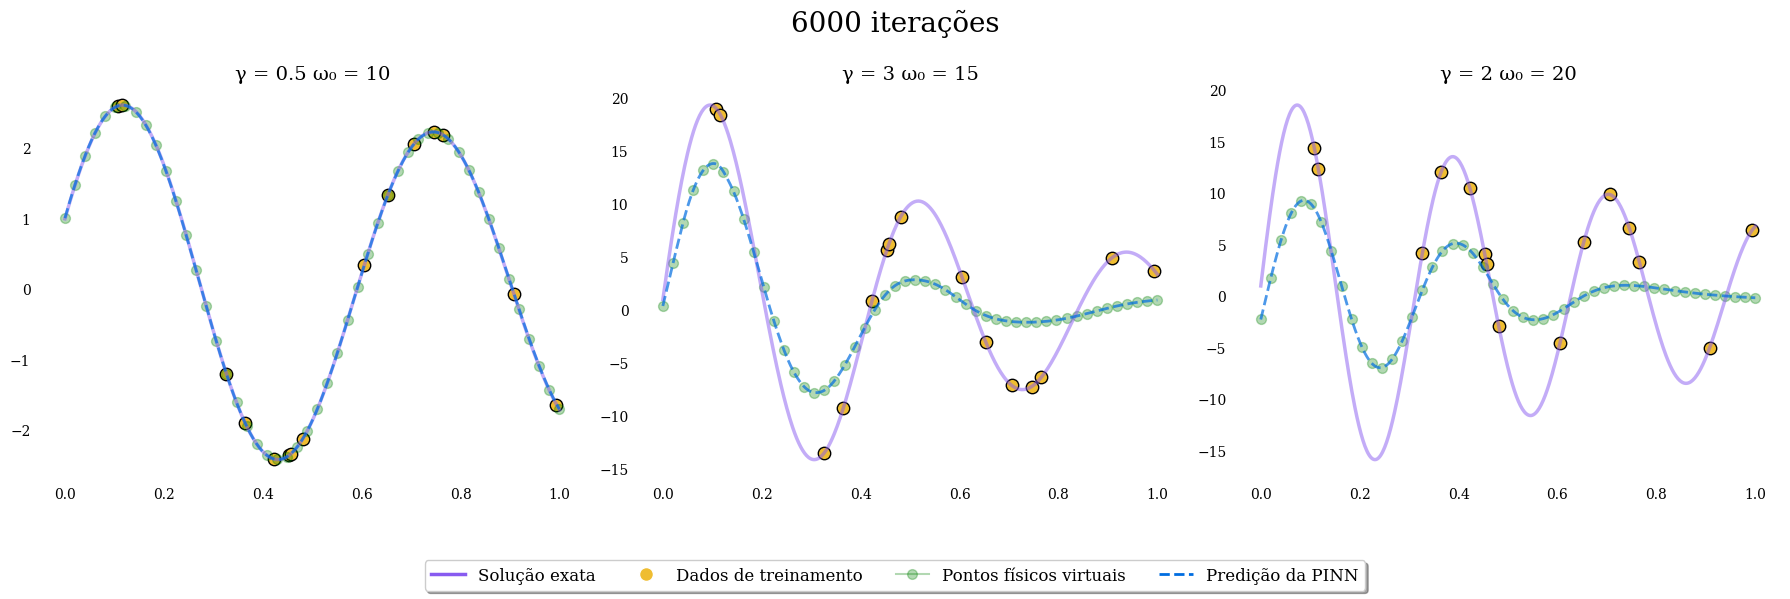

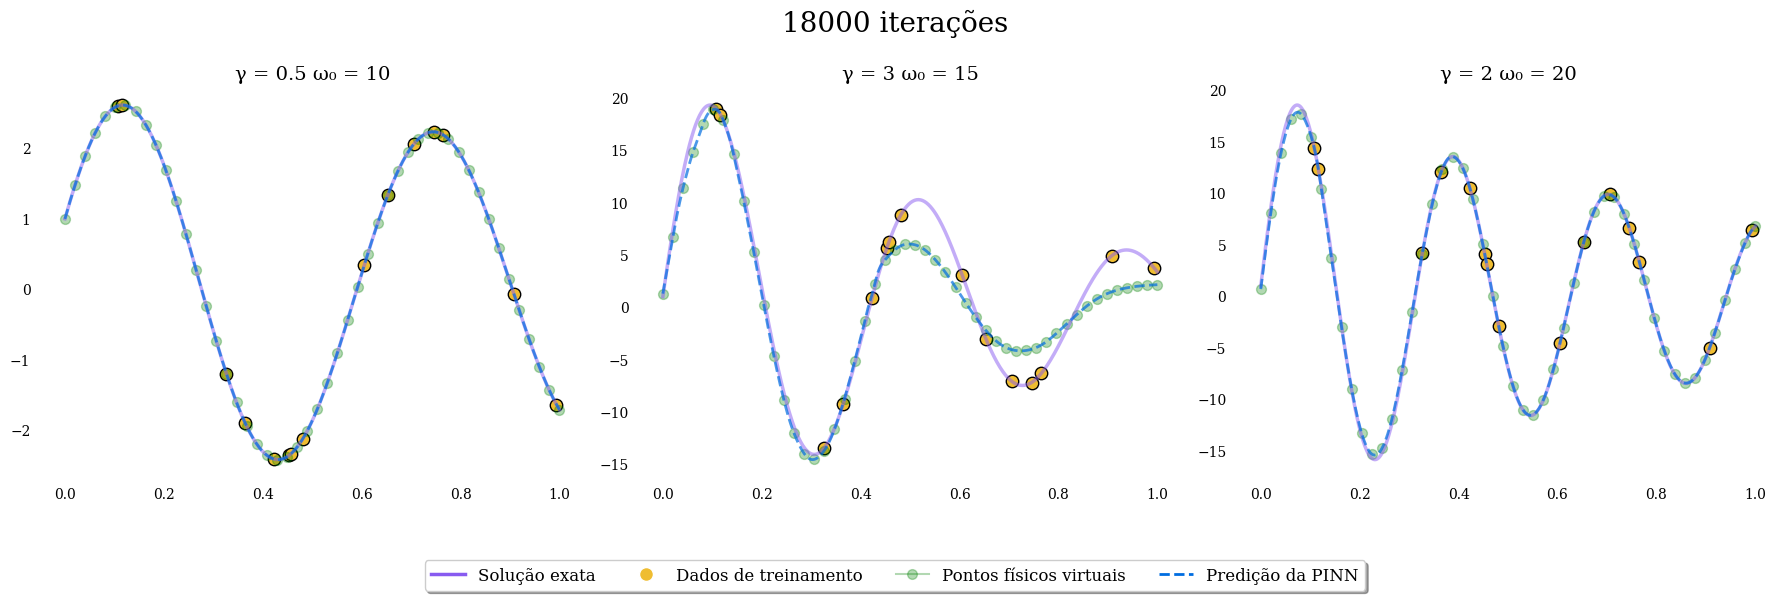

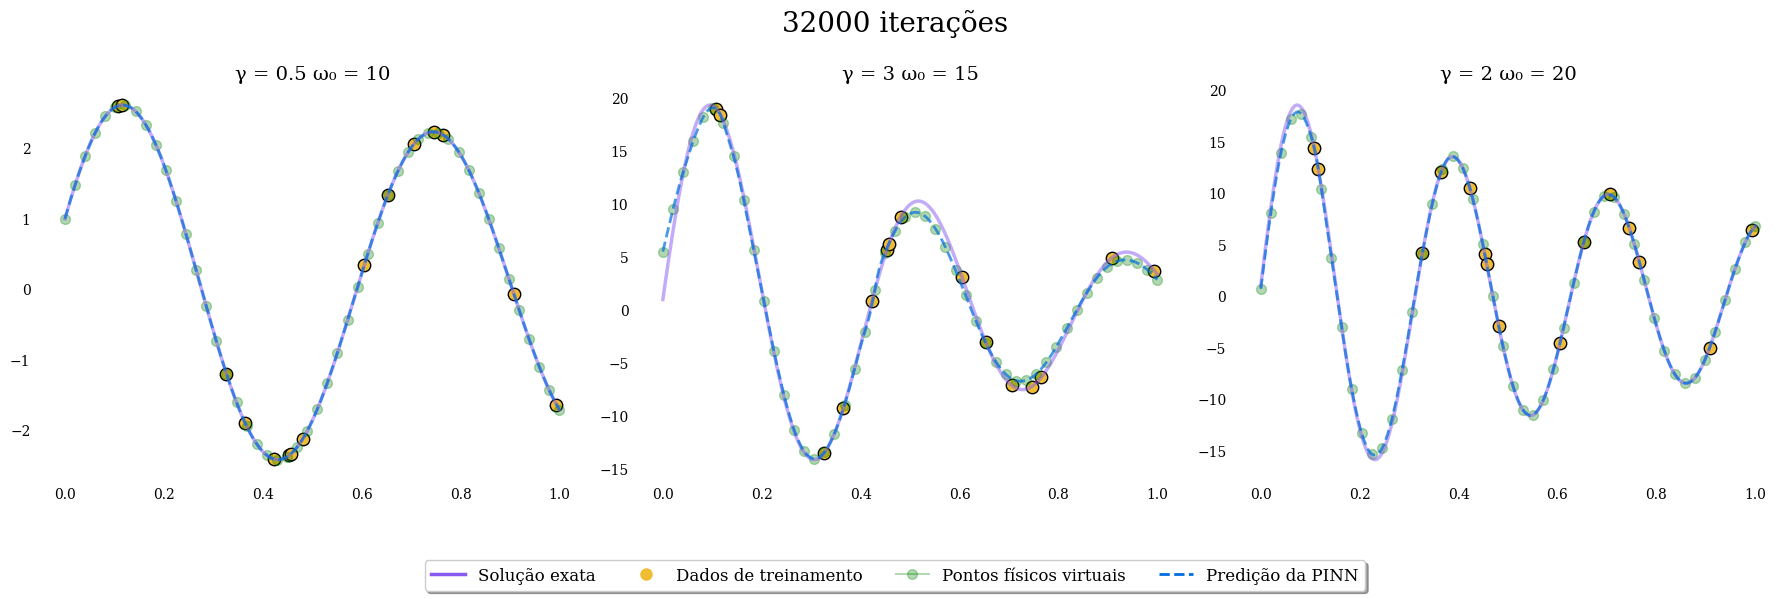

Resultados (Execução em segundos, MAE, MAPE, RMSE, MSE) para cada combinação (gamma, w0) e iteração:
[[[2.72277470e+01 3.29581741e-03 7.58686185e-01 4.17862320e-03
   1.74608922e-05]
  [8.12216630e+01 4.22998244e-04 9.49093699e-02 6.04115485e-04
   3.64955554e-07]
  [1.46043890e+02 4.66727448e-04 9.81696993e-02 4.87616373e-04
   2.37769740e-07]]

 [[2.67317984e+01 4.03517389e+00 7.19936829e+01 4.47187281e+00
   1.99976482e+01]
  [7.97011588e+01 1.65941882e+00 4.04801025e+01 2.14769411e+00
   4.61258984e+00]
  [1.47216087e+02 5.36701024e-01 1.66632767e+01 7.73355782e-01
   5.98079145e-01]]

 [[2.69677365e+01 5.76014376e+00 9.34293442e+01 6.40335560e+00
   4.10029602e+01]
  [8.25014441e+01 1.36925876e-01 2.44854808e+00 2.52508998e-01
   6.37607872e-02]
  [1.45884847e+02 1.32015198e-01 2.25580955e+00 2.45316237e-01
   6.01800531e-02]]]


In [9]:
mu_k = [(2 * (gamma/2), w0 ** 2) for gamma, w0 in params]
iteracoes = [6000, 18000, 32000]

for j, iteracao in enumerate(iteracoes):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    for i, (gamma, w0), (mu, k) in zip(range(len(params)), params, mu_k):
        x = torch.linspace(0, 1, 500).view(-1, 1)
        y = osciHarmSub(gamma, w0, x).view(-1, 1)

        torch.manual_seed(123)
        indices = torch.randperm(len(x))[:num_alea]
        x_data = x[indices]
        y_data = y[indices]

        x_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)

        model = RedeConect(1, 1, 32, 3)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        start_time = time.time()
        for epoch in range(1, iteracao + 1):
            optimizer.zero_grad()

            yh = model(x_data)
            loss1 = torch.mean((yh - y_data) ** 2)

            yhp = model(x_physics)
            dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
            dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
            physics = dx2 + mu * dx + k * yhp
            loss2 = (1e-4) * torch.mean(physics ** 2)

            loss = loss1 + loss2
            loss.backward()
            optimizer.step()
        exec_time = time.time() - start_time

        y_pred = model(x).detach()
        erro_mae = torch.mean(torch.abs(y_pred - y)).item()
        erro_mape = torch.mean(torch.abs((y_pred - y) / y) * 100).item()
        erro_rmse = torch.sqrt(nn.MSELoss()(y_pred, y)).item()
        erro_mse = nn.MSELoss()(y_pred, y).item()

        resultados[i, j, :] = [exec_time, erro_mae, erro_mape, erro_rmse, erro_mse]

        axs[i].plot(x.numpy(), y.numpy(), color="#885BF0", linewidth=2.5, alpha=0.5, label="Solução exata")
        axs[i].scatter(x_data.numpy(), y_data.numpy(), color="#EFBD31", edgecolor="black", s=80, marker="o", label="Dados de treinamento")
        axs[i].scatter(x_physics.detach().numpy(), model(x_physics).detach().numpy(), color="green", alpha=0.3, s=50, label="Pontos físicos virtuais")
        axs[i].plot(x.numpy(), y_pred.numpy(), color="#006DE0", linewidth=2, linestyle="--", alpha=0.7, label="Predição da PINN")
        axs[i].set_title(f"γ = {gamma} ω₀ = {w0}", fontsize=14)
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['bottom'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].tick_params(axis='both', which='both', bottom=False, left=False)

    fig.suptitle(f"{iteracao} iterações", fontsize=20)
    handles = [
        plt.Line2D([0], [0], color="#885BF0", lw=2.5, label="Solução exata"),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#EFBD31", markersize=10, label="Dados de treinamento"),
        plt.Line2D([0], [0], marker='o', color='green', markersize=7, alpha=0.3, label="Pontos físicos virtuais"),
        plt.Line2D([0], [0], color="#006DE0", lw=2, linestyle="--", label="Predição da PINN")
    ]
    fig.legend(handles=handles, loc="lower center", frameon=True, fancybox=True, shadow=True, fontsize=12, ncol=4)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.2)
    plt.savefig(f"iteracao_{iteracao}.png")
    plt.show()

print("Resultados (Execução em segundos, MAE, MAPE, RMSE, MSE) para cada combinação (gamma, w0) e iteração:")
print(resultados)

# TESTE

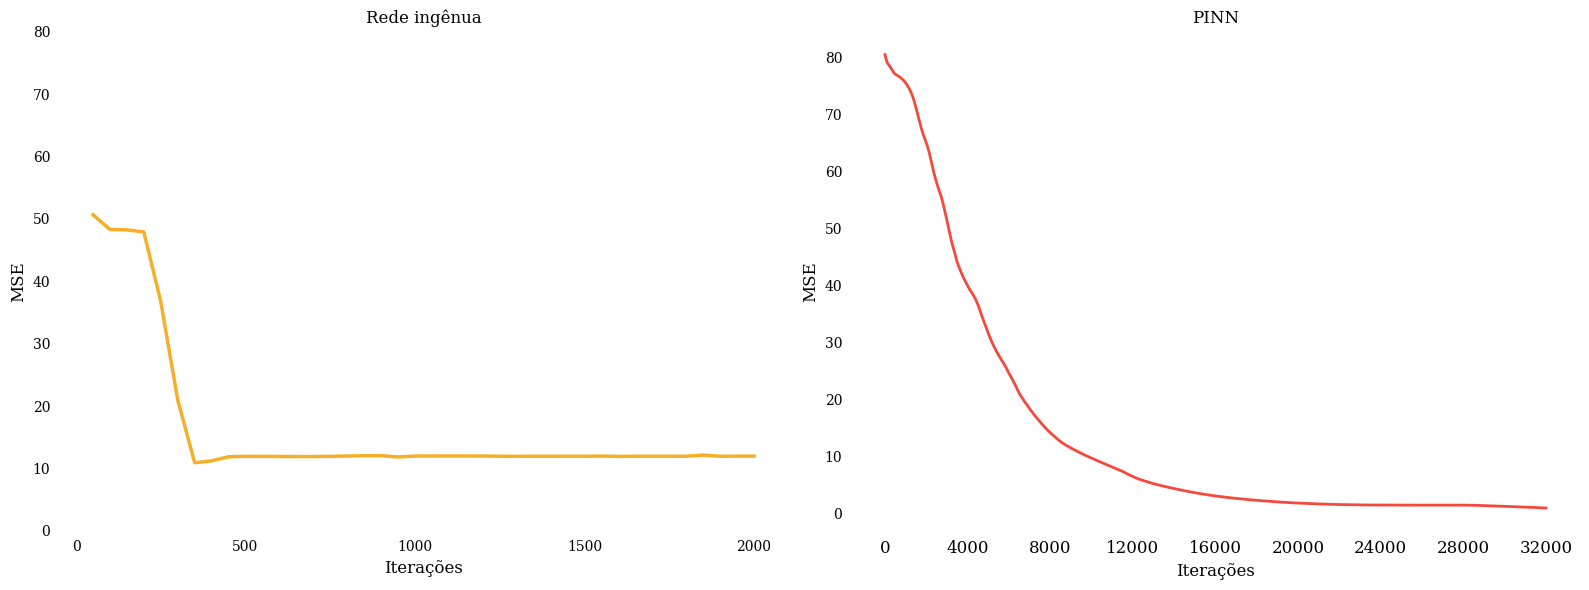

In [10]:
gamma, w0 = 3, 15
num_alea = 15
max_iter_1 = 2000
step = 50
iteracoes_1 = list(range(step, max_iter_1 + step, step))

x = torch.linspace(0, 1, 500).view(-1, 1)
y = osciHarmSub(gamma, w0, x).view(-1, 1)
torch.manual_seed(123)
indices = torch.randperm(len(x))[:num_alea]
x_data = x[indices]
y_data = y[indices]

mse_values = []
model = RedeConect(1, 1, 32, 3)
criterio = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in iteracoes_1:
    for _ in range(step):
        optimizer.zero_grad()
        output = model(x_data)
        loss = criterio(output, y_data)
        loss.backward()
        optimizer.step()

    y_pred = model(x).detach()
    mse = criterio(y_pred, y).item()
    mse_values.append(mse)

mu, k = 2 * (gamma / 2), w0 ** 2
x_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)
mse_history = []
model = RedeConect(1, 1, 32, 3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

max_iter_2 = 32000
for epoch in range(1, max_iter_2 + 1):
    optimizer.zero_grad()
    yh = model(x_data)
    loss1 = torch.mean((yh - y_data) ** 2)

    yhp = model(x_physics)
    dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
    physics = dx2 + mu * dx + k * yhp
    loss2 = (1e-4) * torch.mean(physics ** 2)

    loss = loss1 + loss2
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        y_pred = model(x)
        mse = nn.MSELoss()(y_pred, y).item()
        mse_history.append(mse)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(iteracoes_1, mse_values, color='#F5AF29', linewidth=2.5)
ax1.set_ylim(0, 80)
ax1.set_xticks(range(0, max_iter_1 + 1, 500))
ax1.set_xlabel("Iterações", fontsize=12)
ax1.set_ylabel("MSE", fontsize=12)
ax1.set_title("Rede ingênua", fontsize=12)
ax1.grid(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)  # Remove os ticks

ax2.plot(range(1, max_iter_2 + 1), mse_history, color="#F5493C", linewidth=2)
ax2.set_xticks(np.arange(0, max_iter_2 + 1, 4000))
ax2.set_xticklabels(np.arange(0, max_iter_2 + 1, 4000), fontsize=12, color="black")
ax2.set_xlabel("Iterações", fontsize=12)
ax2.set_ylabel("MSE", fontsize=12)
ax2.set_title("PINN", fontsize=12)
ax2.grid(False)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)  # Remove os ticks

plt.tight_layout()
plt.show()


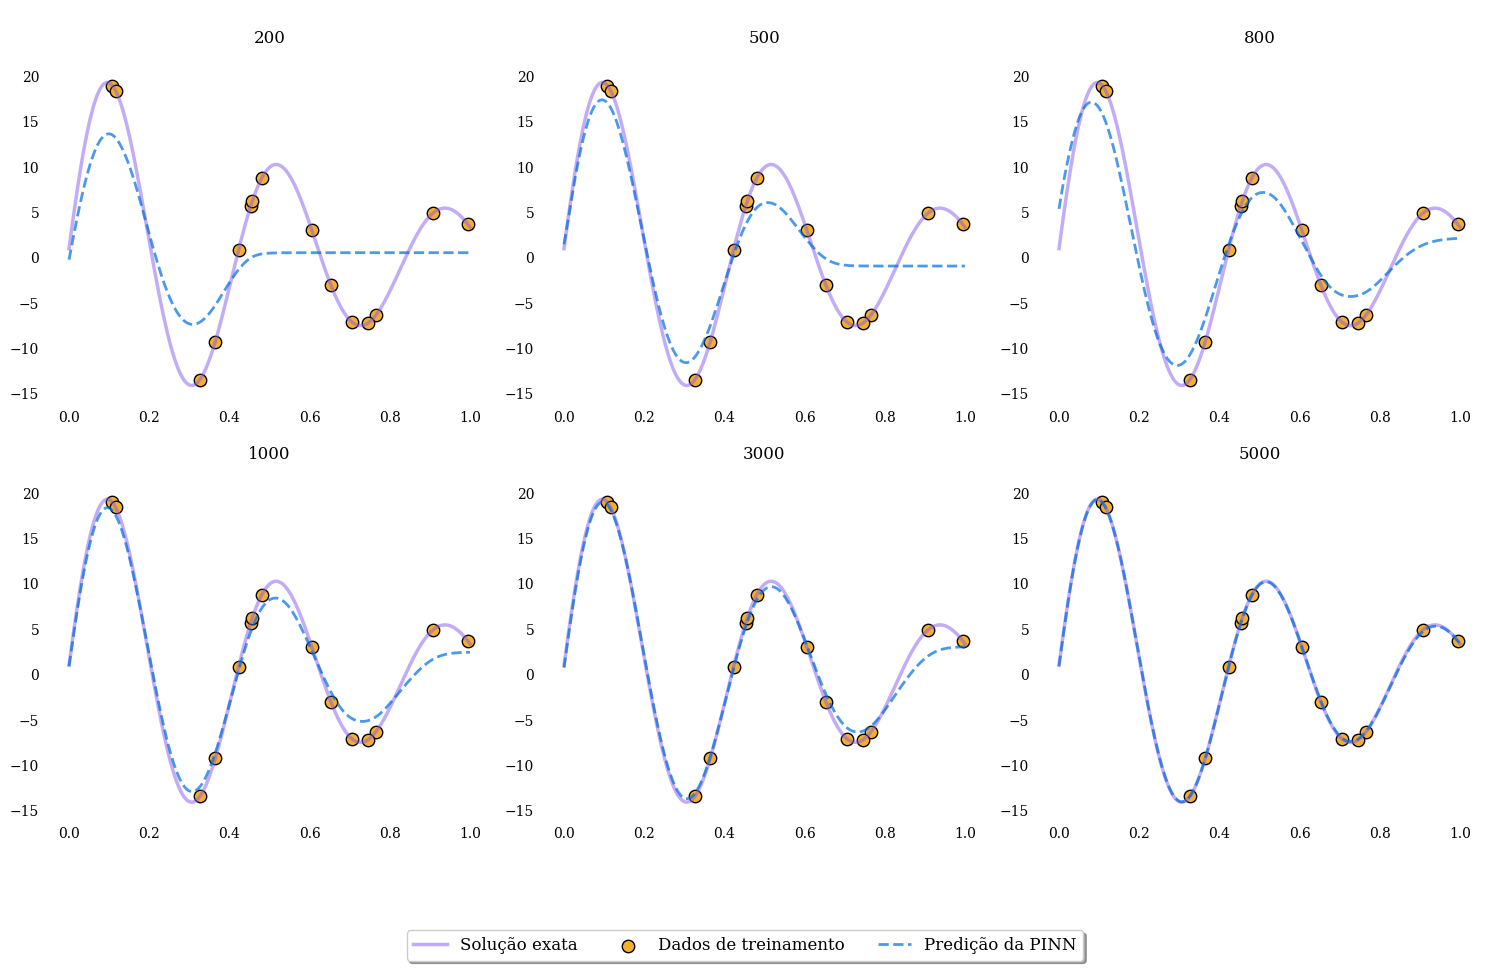

In [11]:
gamma, w0 = 3, 15
mu, k = 2 * (gamma / 2), w0 ** 2
num_alea = 15

error_decay_final = []
predicoes_por_iteracao = []

x = torch.linspace(0, 1, 500).view(-1, 1)
y = osciHarmSub(gamma, w0, x).view(-1, 1)

torch.manual_seed(123)
indices = torch.randperm(len(x))[:num_alea]
x_data = x[indices]
y_data = y[indices]

x_physics = torch.linspace(0, 1, 50).view(-1, 1).requires_grad_(True)

model = RedeConect(1, 1, 32, 3)
criterio = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

start_time = time.time()
loss_anterior = float('inf')
epoch = 0
pinn_phase = False

it_iteracoes = [200, 500, 800, 1000, 3000, 5000]
predicoes_por_iteracao = {i: None for i in it_iteracoes}

while True:
    optimizer.zero_grad()

    if not pinn_phase:
        output = model(x_data)
        loss = criterio(output, y_data)
    else:
        yh = model(x_data)
        loss1 = torch.mean((yh - y_data) ** 2)

        yhp = model(x_physics)
        dx = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
        dx2 = torch.autograd.grad(dx, x_physics, torch.ones_like(dx), create_graph=True)[0]
        physics = dx2 + mu * dx + k * yhp
        loss2 = (1e-4) * torch.mean(physics ** 2)

        loss = loss1 + loss2

    loss.backward()
    optimizer.step()

    proporcao_erro = abs((loss_anterior - loss.item()) / loss_anterior)
    error_decay_final.append(loss.item())
    epoch += 1

    if epoch in it_iteracoes:
        predicoes_por_iteracao[epoch] = model(x).detach()

    if not pinn_phase and proporcao_erro < 0.05:
        pinn_phase = True

    loss_anterior = loss.item()

    if epoch > 5000:
        break

exec_time = time.time() - start_time

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, iteracao in enumerate(it_iteracoes):
    ax = axs[i // 3, i % 3]
    y_pred_iteracao = predicoes_por_iteracao[iteracao]

    ax.plot(x.numpy(), y.numpy(), color="#885BF0", linewidth=2.5, alpha=0.5, label="Solução exata")
    ax.scatter(x_data.numpy(), y_data.numpy(), color="#F5AF29", edgecolor="black", s=80, marker="o", label="Dados de treinamento")
    ax.plot(x.numpy(), y_pred_iteracao.numpy(), color="#006DE0", linewidth=2, linestyle="--", alpha=0.7, label="Predição da PINN")

    ax.set_title(f"\n{iteracao}", fontsize=12, y=1.05)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', bottom=False, left=False)

fig.suptitle("", fontsize=16)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", fontsize=12, ncol=3, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.subplots_adjust(top=0.9, bottom=0.15)
plt.show()

